## 1. Setup Notebook Environment

### 1.1 Import all required packages.

In [87]:
import ssl
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.datasets import EuroSAT
from torchvision import models,transforms

import avalanche.benchmarks as av_b

from avalanche.benchmarks import nc_benchmark
from avalanche.benchmarks.utils import as_classification_dataset
from avalanche.benchmarks.datasets import default_dataset_location 
from avalanche.benchmarks import benchmark_with_validation_stream
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics, \
    loss_metrics, timing_metrics, cpu_usage_metrics, confusion_matrix_metrics, disk_usage_metrics
from avalanche.logging import InteractiveLogger, TextLogger, TensorboardLogger
from avalanche.training.plugins import EvaluationPlugin
from avalanche.training.supervised import Naive

### 1.2 Configure settings for the optimizer and scheduler.

In [88]:
config = {'train_test_split':0.1, # train test split ratio
            'tr_val_split':0.2, # train validation split ratio
            'seed':42, # random seed
            'mini_batch_size':128,
            'mini_batch_eval_size':128,

            'epochs':20,
            
            # Settings for the optimizer AdamW
            'lr':1e-3, # learning rate
            'weight_decay':5e-4,

            # Settings for the lr_scheduler CosineAnnealingWarmRestarts
            't_0':5, # Number of iterations for the first restart.
            'eta_min':1e-5, # Minimum learning rate
          }

### 1.3 Define a function to set a random seed for reproducibility assurance:
* Manage sources of randomness that may lead to varying behaviors in multiple executions of your application.

In [89]:
def set_random_seed(seed=42):
    random.seed(seed) # set python seed
    np.random.seed(seed) # seed the global NumPy random number generator(RNG)
    torch.manual_seed(seed) # seed the RNG for all devices(both CPU and CUDA) 

set_random_seed(seed=config['seed'])

### 1.4 Tracks the active GPU and allocates all new CUDA tensors on that device by default.

In [90]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

## 2. Data Preparation:

### 2.1 Preparing the dataset and benchmark:

In [91]:
datadir = default_dataset_location('eurosat')
# Transform pipeline
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# Dataset download
ssl._create_default_https_context = ssl._create_unverified_context # Turn off the ssl verification.
dataset = EuroSAT(root=datadir,transform=transform, download=True)
dataset = as_classification_dataset(dataset)
eurosat_train, eurosat_test= av_b.split_validation_random(config['train_test_split'],dataset=dataset,shuffle=True,seed=config["seed"])

benchmark = nc_benchmark(eurosat_train,eurosat_test,n_experiences=5,task_labels=True,shuffle=True,seed=config["seed"])
benchmark = benchmark_with_validation_stream(benchmark,validation_size=config["tr_val_split"],shuffle=True,seed=config["seed"])

/home/giuseppe/miniconda3/envs/Earth_Observation/lib/python3.10/site-packages/avalanche/benchmarks/scenarios/supervised.py:389: UserWarning: stream generator will be converted to a list.
  warnings.warn("stream generator will be converted to a list.")


### 2.2 Visualize Training Data

Image 20952 's label : 6 PermanentCrop


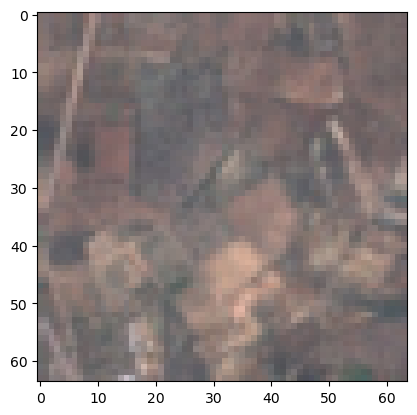

In [92]:
# Randomly select an image from the Training Data for visualization and print its corresponding label.
classes = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
random_index = random.randrange(len(eurosat_train)) # random select an index
random_image = eurosat_train[random_index][0].numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
random_image = std * random_image + mean
random_image = np.clip(random_image, 0, 1)
print("Image", random_index, "'s label :", eurosat_train[random_index][1], classes[eurosat_train[random_index][1]])
plt.imshow(random_image)

## 3. Model Training

### 3.1 Instantiate Model and define criterion and optimizer

In [93]:
num_classes = 10
model = models.resnet50(weights="DEFAULT")
model.fc = nn.Linear(model.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

In [94]:
# log to Tensorboard
tb_logger = TensorboardLogger()
# log to text file
text_logger = TextLogger(open('log.txt', 'a'))

# print to stdout
interactive_logger = InteractiveLogger()

eval_plugin = EvaluationPlugin(
    accuracy_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loss_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    forgetting_metrics(experience=True, stream=True),
    cpu_usage_metrics(experience=True),
    confusion_matrix_metrics(num_classes=num_classes, save_image=False,
                             stream=True),
    disk_usage_metrics(minibatch=True, epoch=True, experience=True, stream=True),
    loggers=[interactive_logger, text_logger, tb_logger]
)

from torch.optim import SGD
from torch.nn import CrossEntropyLoss

cl_strategy = Naive(
    model, optimizer, criterion,
    train_mb_size=config["mini_batch_size"],
    train_epochs=config["epochs"],
    eval_mb_size=config["mini_batch_eval_size"],
    device=device,
    evaluator=eval_plugin
)


print(benchmark)


# TRAINING LOOP
print('Starting experiment...')
results = []
for experience in benchmark.train_stream:
    print("Start of experience: ", experience.current_experience)
    print("Current Classes: ", experience.classes_in_this_experience)

    # train returns a dictionary which contains all the metric values
    res = cl_strategy.train(experience)
    print('Training completed')

    print('Computing accuracy on the whole test set')
    # test also returns a dictionary which contains all the metric values
    results.append(cl_strategy.eval(benchmark.test_stream))

/home/giuseppe/miniconda3/envs/Earth_Observation/lib/python3.10/site-packages/avalanche/training/templates/base.py:468: PositionalArgumentsDeprecatedWarning: Avalanche is transitioning to strategy constructors that accept named (keyword) arguments only. This is done to ensure that there is no confusion regarding the meaning of each argument (strategies can have many arguments). Your are passing 3 positional arguments to the Naive.__init__ method. Consider passing them as names arguments. The ability to pass positional arguments will be removed in the future.
  warnings.warn(error_str, category=PositionalArgumentsDeprecatedWarning)


Starting experiment...
Start of experience:  0
Current Classes:  {2, 6}
-- >> Start of training phase << --


100%|██████████| 31/31 [01:05<00:00,  2.12s/it]
Epoch 0 ended.
	DiskUsage_Epoch/train_phase/train_stream = 50.2832
	DiskUsage_MB/train_phase/train_stream = 50.2832
	Loss_Epoch/train_phase/train_stream = 0.3098
	Loss_MB/train_phase/train_stream = 0.0867
	RunningTime_Epoch/train_phase/train_stream = 0.0808
	Time_Epoch/train_phase/train_stream = 65.8047
	Top1_Acc_Epoch/train_phase/train_stream = 0.9115
	Top1_Acc_MB/train_phase/train_stream = 0.9569
 87%|████████▋ | 27/31 [01:00<00:08,  2.24s/it]

KeyboardInterrupt: 